In [3]:
%matplotlib inline


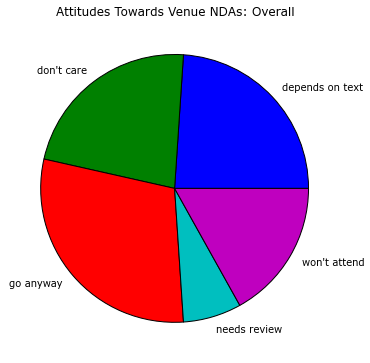

In [4]:
import psycopg2
from pylab import *

conn=psycopg2.connect('dbname=statsdemo')
cur = conn.cursor()
cur.execute("""SELECT att, count(*) as members 
    FROM ndasurvey GROUP BY att ORDER BY att""");

labels = []
fracs = []
explode = []
for rec in cur:
    labels.append(rec[0])
    fracs.append(rec[1])

figure(1, figsize=(6,6))

pie(fracs, labels=labels)

title('Attitudes Towards Venue NDAs: Overall')

show()

conn.close()

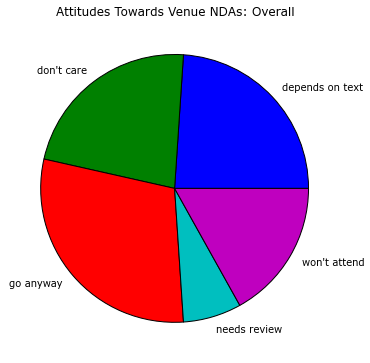

In [5]:
import psycopg2
from pylab import *

conn=psycopg2.connect('dbname=statsdemo')
cur = conn.cursor()
cur.execute("""WITH counts AS (SELECT att, 
    count(*) as members
    FROM ndasurvey GROUP BY att ORDER BY att)
    SELECT array_agg(att), 
        array_agg(members)
    FROM counts;""");

for rec in cur:
    labels = rec[0]
    fracs = rec[1]
  
figure(1, figsize=(6,6))

pie(fracs, labels=labels)

title('Attitudes Towards Venue NDAs: Overall')

show()

conn.close()

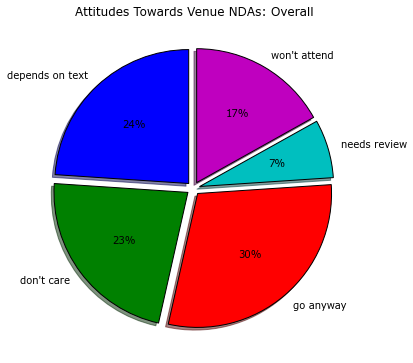

In [6]:
import psycopg2
from pylab import *

conn=psycopg2.connect('dbname=statsdemo')
cur = conn.cursor()
cur.execute("""WITH counts AS (SELECT att, 
    count(*) as members,
    0.05::float as explode 
    FROM ndasurvey GROUP BY att ORDER BY att)
    SELECT array_agg(att), 
        array_agg(members),
        array_agg(explode)
    FROM counts;""");

for rec in cur:
    labels = rec[0]
    fracs = rec[1]
    explode = rec[2]
  
figure(1, figsize=(6,6))

pie(fracs, explode=explode, labels=labels,
                autopct='%1.0f%%', shadow=True, startangle=90)

title('Attitudes Towards Venue NDAs: Overall')

show()

conn.close()

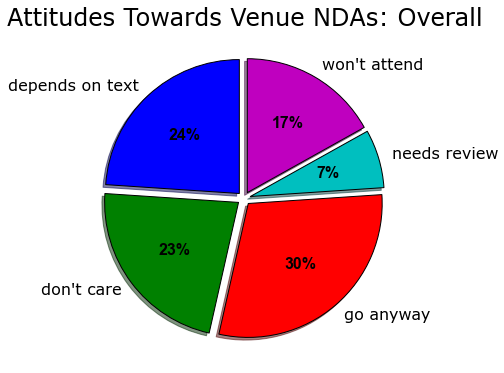

In [7]:
import psycopg2
from pylab import *

conn=psycopg2.connect('dbname=statsdemo')
cur = conn.cursor()
cur.execute("""WITH counts AS (SELECT att, 
    count(*) as members,
    0.05::float as explode 
    FROM ndasurvey GROUP BY att ORDER BY att)
    SELECT array_agg(att), 
        array_agg(members),
        array_agg(explode)
    FROM counts;""");

for rec in cur:
    labels = rec[0]
    fracs = rec[1]
    explode = rec[2]
  
figure(1, figsize=(6,6))

patches, texts, autotexts = pie(fracs, explode=explode, labels=labels,
                autopct='%1.0f%%', shadow=True, startangle=90)
[t.set_fontsize(16) for t in texts]
[a.set_fontsize(16) for a in autotexts]
[a.set_fontweight("bold") for a in autotexts]

title('Attitudes Towards Venue NDAs: Overall', fontsize = 24)

show()

conn.close()

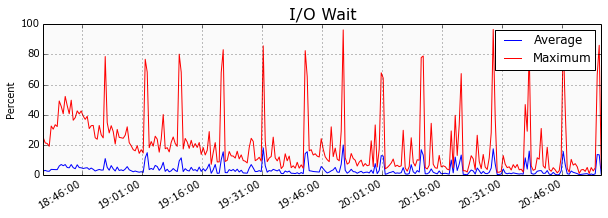

In [8]:
import matplotlib.pyplot as plot
from matplotlib import dates


conn=psycopg2.connect('dbname=statsdemo')
cur = conn.cursor()
cur.execute("""WITH maggs AS ( 
    SELECT measurement_time AS mtime, 
       max(periowait)::float as maxwait, 
       avg(periowait)::float as avgwait
    FROM cpu
    WHERE cpu <> 'all'
    GROUP BY measurement_time
    ORDER BY measurement_time
    )
    SELECT array_agg(mtime), array_agg(avgwait), array_agg(maxwait)
    FROM maggs;
""")

for r in cur:
    timeseries = r[0]
    avg_io_wait = r[1]
    max_io_wait = r[2]

fig = plot.figure(figsize=(10,3))
ax = fig.add_subplot(111, axisbg='#fafafa', alpha=0.9)
hfmt = dates.DateFormatter('%H:%M:%S')
ax.xaxis_date()
ax.xaxis.set_major_formatter(hfmt)

ax.plot(timeseries, avg_io_wait, color='blue', label='Average')
ax.plot(timeseries, max_io_wait, color='red', label='Maximum')

ax.set_title('I/O Wait', fontsize=16)

ax.set_ylabel('Percent')

ax.grid(True)

ax.legend(loc='upper right')

fig.autofmt_xdate()

plot.show()

conn.close()


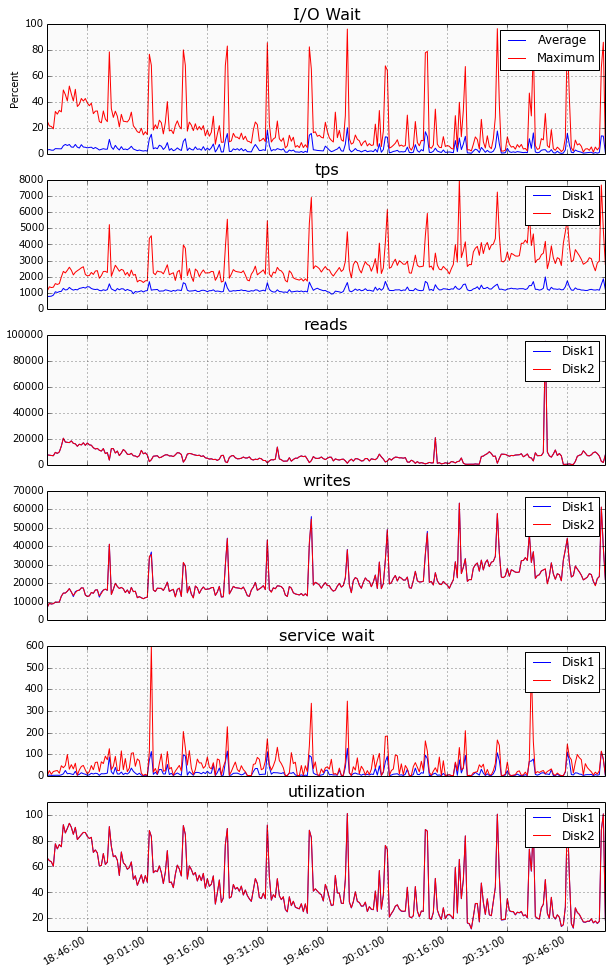

In [9]:
import matplotlib.pyplot as plot
from matplotlib import dates
import psycopg2
from psycopg2.extras import RealDictCursor


conn=psycopg2.connect('dbname=statsdemo', cursor_factory=RealDictCursor)
cur = conn.cursor()
cur.execute("""WITH maggs AS ( 
    SELECT measurement_time AS mtime, 
       max(periowait)::float as maxwait, 
       avg(periowait)::float as avgwait
    FROM cpu
    WHERE cpu <> 'all'
    GROUP BY measurement_time
    ORDER BY measurement_time
    )
    SELECT array_agg(mtime) as mtimes, 
        array_agg(avgwait) as avgwaits,
        array_agg(maxwait) as maxwaits
    FROM maggs;
""")

for r in cur:
    timeseries = r["mtimes"]
    avg_io_wait = r["avgwaits"]
    max_io_wait = r["maxwaits"]
    
ax = {}

fig = plot.figure(figsize=(10,18))

ax["iowait"] = fig.add_subplot(611, axisbg='#fafafa')
hfmt = dates.DateFormatter('%H:%M:%S')
ax["iowait"].xaxis_date()
ax["iowait"].xaxis.set_major_formatter(hfmt)

ax["iowait"].plot(timeseries, avg_io_wait, color='blue', label='Average')
ax["iowait"].plot(timeseries, max_io_wait, color='red', label='Maximum')

ax["iowait"].set_title('I/O Wait', fontsize=16)

ax["iowait"].set_ylabel('Percent')

ax["iowait"].grid(True)

ax["iowait"].legend(loc='upper right')

cur.execute("""
SELECT CASE WHEN dev = 'dev8-0' THEN 'disk1' ELSE 'disk2' END as disk,
    array_agg(measurement_time order by measurement_time) as mtime,
    array_agg(tps order by measurement_time) as tps,
    array_agg(rd_sec_s order by measurement_time) as reads,
    array_agg(wr_sec_s order by measurement_time) as writes,
    array_agg(await order by measurement_time) as "service wait",
    array_agg(perutil order by measurement_time) as utilization
FROM disk
WHERE dev in ('dev8-0','dev253-1')
GROUP BY dev
ORDER BY dev;
""")

ddata = {}

for r in cur:
    dev = r["disk"]
    ddata[dev] = r
    
grpos = 611

for grstat in ["tps","reads","writes","service wait","utilization"]:
    
    grpos += 1
    
    ax[grstat] = fig.add_subplot(grpos, axisbg='#fafafa')
    
    ax[grstat].xaxis_date()
    ax[grstat].xaxis.set_major_formatter(hfmt)

    ax[grstat].plot(ddata["disk1"]["mtime"], ddata["disk1"][grstat], color='blue', label='Disk1')
    ax[grstat].plot(ddata["disk1"]["mtime"], ddata["disk2"][grstat], color='red', label='Disk2')

    ax[grstat].set_title(grstat, fontsize=16)

    ax[grstat].grid(True)

    ax[grstat].legend(loc='upper right')

fig.autofmt_xdate()

plot.show()


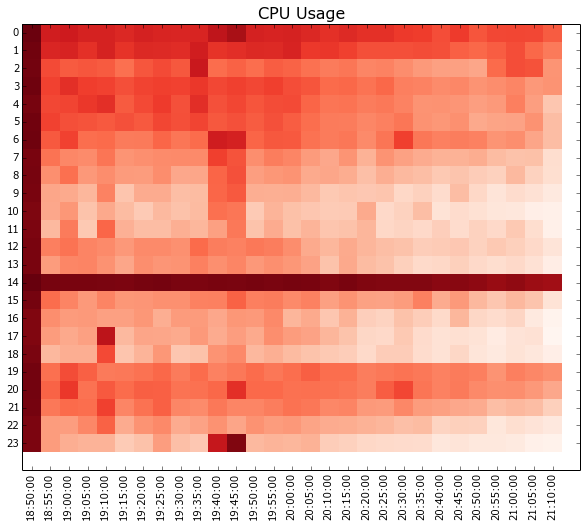

In [10]:
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
import psycopg2
from psycopg2.extras import RealDictCursor


conn=psycopg2.connect('dbname=statsdemo', cursor_factory=RealDictCursor)
cur = conn.cursor()
cur.execute("""
    WITH cpu_data AS (
        SELECT cpu::INT as cpu,
        trunc_5min(measurement_time) as mtime,
        (100-peridle)::float as busy
        FROM cpu1
        WHERE cpu <> 'all'
    ), cpu_max AS (
        SELECT cpu, 
            to_char(mtime, 'HH24:MI:SS') as mtime,
            max(busy) AS busy
        FROM cpu_data
        GROUP BY cpu, mtime
        ORDER BY cpu, mtime
    )
    SELECT cpu::INT as cpu, 
        array_agg(mtime) as mtime, 
        array_agg(busy) as busy 
    FROM cpu_max
    GROUP BY cpu
    ORDER BY cpu;
""")

cpus = []
busy = []
timeseries = None
for r in cur:
    cpu = r["cpu"]
    cpus.append(cpu)
    if timeseries is None:
        timeseries = r["mtime"]
    busy.append(r["busy"])
    
data = np.array(busy)

fig, ax = plt.subplots(figsize=(10,8))

heatmap = ax.pcolor(data, cmap=plt.cm.Reds)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()

ax.set_xticklabels(timeseries, minor=False, rotation='vertical')
ax.set_yticklabels(cpus, minor=False)

ax.set_title('CPU Usage', fontsize=16)

plot.show()
